In [1]:
def launch_environment():
    %matplotlib inline
    import warnings
    warnings.filterwarnings('ignore')
    from sklearn.ensemble import GradientBoostingRegressor
    from functools import partial
    import numpy as np
    import matplotlib.pyplot as plt

    from pyinterpret.core.explanations import Interpretation
    from sklearn.linear_model import LinearRegression
    
    global np
    global plt
    global plot_interaction_example
    global LinearRegression
    global Interpretation
    global GradientBoostingRegressor
    global partial
    global plot_1D_pdps
    global plot_pdp_with_points
    
    def plot_interaction_example():
        x = np.array(range(100))
        y1 = 100 - x
        y2 = x
        y3 = np.ones(100) * 50

        f, ax = plt.subplots(1)
        ax.plot(x, y3, label = 'pdp(N cookies)')
        ax.plot(x, y1, label = 'pdp(N cookies) after large meal')
        ax.plot(x, y2, label = 'pdp(N cookies) without meal')
        ax.set_xlabel('Number of Cookies', fontsize = 18)
        ax.set_ylabel('Average Utility', fontsize = 18)
        ax.set_title("How interactions affect PDP")

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)

        print """
PDP looks flat, but in reality PDP increases or decreases depending on hunger.
        """
        
    def plot_1D_pdps():
    
        from pyinterpret.core.explanations import Interpretation
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.datasets import load_boston, load_breast_cancer
        from sklearn.linear_model import LinearRegression
        from sklearn.neighbors import KNeighborsRegressor

        data = load_boston()
        X, y, features = data.data, data.target, data.feature_names

        model1 = GradientBoostingRegressor()
        model1.fit(X, y)

        model2 = LinearRegression()
        model2.fit(X, y)

        model3 = KNeighborsRegressor()
        model3.fit(X, y)

        feature_id = model1.feature_importances_.argsort()[-1:]
        feature_names = [features[i] for i in feature_id]

        interpreter = Interpretation()
        interpreter.load_data(data.data, feature_names = features)
        f, ax = interpreter.partial_dependence.plot_partial_dependence(feature_names, model2.predict, 
                                                                       with_variance=True)
        ax.set_ylim(10,42)
        ax.set_title("Linear Regression")
        ax.text(8.5, 20, r'Slope of PDP $\approx \frac{\partial Regression}{\partial RM} = \beta_{RM}$',fontsize = 24)
        f, ax = interpreter.partial_dependence.plot_partial_dependence(feature_names, model1.predict,
                                                                      with_variance=True)
        ax.set_ylim(10,42)
        ax.text(8.5, 20, r'Slope of PDP $\approx \frac{\partial GBR}{\partial RM}$',fontsize = 24)
        ax.set_title("Gradient Boosted Regressor")

        f, ax = interpreter.partial_dependence.plot_partial_dependence(feature_names, model3.predict,
                                                                      with_variance=True)
        ax.set_ylim(10,42)
        ax.text(8.5, 20, r'Slope of PDP $\approx \frac{\partial KNN}{\partial RM}$',fontsize = 24)
        ax.set_title("Nearest Neighbors Regressor")
        
    def plot_pdp_with_points(point1, point2, interpreter, f, example1, example2):
        #['N Cookies','Hunger Level','Time of Day']
        pdp = interpreter.partial_dependence.partial_dependence(['N Cookies','Hunger Level'], f, grid_resolution=30)
        fig, ax = interpreter.partial_dependence.plot_partial_dependence(['N Cookies','Hunger Level'], f, grid_resolution=30)

        grid_point1 = abs(pdp[['val_N Cookies', 'val_Hunger Level']].values - point1).sum(axis=1).argmin()
        z1 = pdp.iloc[grid_point1]['mean']
        example_coords1 = np.append(example1[:2].copy(), z1)
        example_coords1[0] -= 5
        example_coords1[2] += 15
        example_coords1 = example_coords1[:, np.newaxis]
        ax.scatter(*example_coords1, s = 100)

        grid_point2 = abs(pdp[['val_N Cookies', 'val_Hunger Level']].values - point2).sum(axis=1).argmin()
        z2 = pdp.iloc[grid_point2]['mean']
        example_coords2 = np.append(example2[:2].copy(), z2)
        example_coords2 = example_coords2[:, np.newaxis]
        ax.scatter(*example_coords2, s = 100)        






### Model Interpretation: Reasoning about machine learning models

### Interpretation $\neq$ Validation


#### Validation: 
* Will a model provide accurate predictions on new data?
* Assuming new data is drawn from the same population as my validation data, this gives me performance expectations.

<table id="customers">
  <tbody>
  <tr>
    <th> </th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
    <th>Support</th>
  </tr>
  <tr>
    <th>Class 1 </th>
    <th>85%</th>
    <th>80%</th>
    <th>82%</th>
    <th>30%</th>
  </tr>
  <tr>
    <th>Class 2 </th>
    <th>55%</th>
    <th>65%</th>
    <th>60%</th>
    <th>70%</th></tr></tbody></table>
    
#### Implementation:
1) Collect a number of observations not used in training

2) Collect true values for these observations

3) Generate predictions

4) Calculate metrics comparing (2) and (3)

### Interpretation: 
* How does my model make decisions (what is its decision function)?

#### Why Interpret?: 
* Use model to inform policy
    * "Should I buy leads with characteristic X?
* Trust the model
    * "Does the model seem to be reasonable?"
* Prevent bad behavior
    * "What happens when an observation has extreme values?"
    * "Is that information available in production setting?"

<img src='regression_coef.png'>
<br>


<br>
<img src='http://cdn.edureka.co/blog/wp-content/uploads/2015/01/tree2.png' style="width:600px;height:328px;">

#### Implementation: 
* Store model attributes during training in memory
* No standard way + depends on model

### Issues with Current thinking on Interpretation
* Lack of common framework across model types
<br>
<br>
* Interpretations are limited to information the model can provide
<br>
<br>
* "Floating models" can not be interpreted this way.
<br>
<br>
* Practioners that need to trust their model contrain model choices based on available interpretations.



### Properties we want: 
##### Model Agnostic: 
* Use a common set of visualizations, metrics, and statistics to interpret any model.

##### Model as a black box : 
* We do not want to rely on the model being available in memory. 
* Want to learn from patterns between inputs and outputs.


### Model Agnostic Interpretation: Gradients + Surrogates

#### Feature Gradients: Generalizing Regression Coefficients
Question: What is the effect of $x_1$ on $\hat{y}$, according to some arbitrary model f?

Answer: The partial derivative of f with respect to $x_1$

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


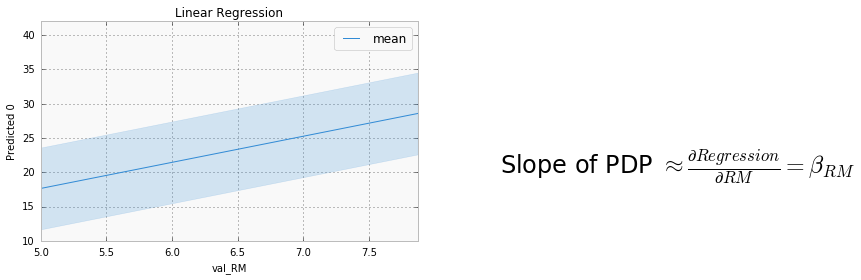

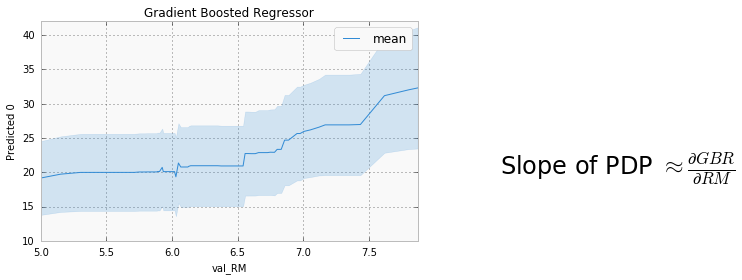

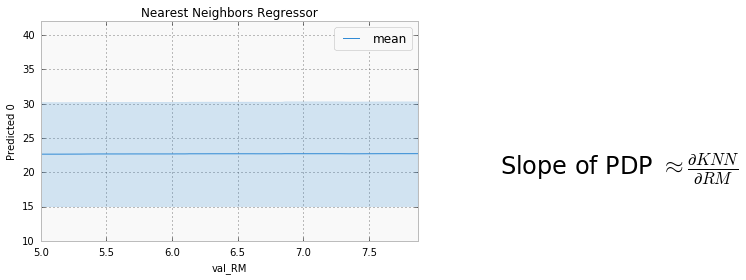

In [2]:
launch_environment()
plot_1D_pdps()

##### Interpretation:
* How does the model use $x_i$, controlling for other features (usually when $x_i$ is varied, $x_2$ and $x_3$ also vary because they are correlated. Hold $x_2$ and $x_3$ constant, and vary $x_i$).

* Can it handle non linearity? 
    * YES, THATS THE POINT.
* Can it handle interactions? 
    * NO :(

##### Uncovering pairwise interactions: 2D Partial Depedence

Plots above represent $\frac{\partial f}{\partial x_1}$.
What if $\frac{d f}{d x_1}$ depends on $x_2$?

#### Example: Cookies

Survey: 
* How satisfied are you?

Variables: 
* What time of day is it?
* How many cookies did you just eat?
* How hungry were you before eating the cookies?

Train a random forest to predict satisfaction from these variables.

Research Question: How does the number of cookies you eat affect satisfaction?



PDP looks flat, but in reality PDP increases or decreases depending on hunger.
        


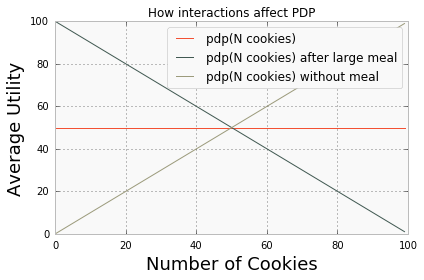

In [3]:
plot_interaction_example()

### Strategies for identifying interaction:
* Look at variance of pdp: high variance could indicate dependence.
* Look at feature importance. Flat PDP + high importance = interaction
* TODO: algorithm

In [13]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from functools import partial

x = np.random.choice(range(100), size=(1000, 3))


def round_to(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)

def get_satisfaction(x):
    cookies, hunger, time_of_day = x
    base = round_to(hunger, base = 30)
    cookie_slope = (50 - base)/50 * -1
    hunger_slope = -1
    satisfaction = cookie_slope * cookies + hunger_slope * hunger + 50
    return float(satisfaction) + np.random.normal(0, 10.)




    

satisfation_function = partial(np.apply_along_axis, *[get_satisfaction, 1])

gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(x, satisfation_function(x))


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

We can condition on x2 as well, to calculate pdp(x1,x2):

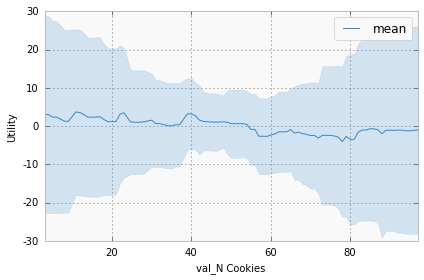

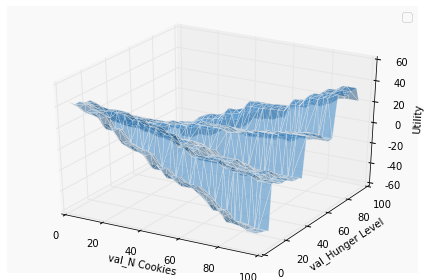

In [14]:
from pyinterpret.core.explanations import Interpretation

interpreter = Interpretation(log_level=30)
interpreter.load_data(x, feature_names=['N Cookies','Hunger Level','Time of Day'])

fig, ax = interpreter.partial_dependence.plot_partial_dependence(['N Cookies'], 
                                                                 gbr.predict, 
                                                                 with_variance=True)
ax.set_ylabel("Utility")
fig, ax = interpreter.partial_dependence.plot_partial_dependence(['N Cookies','Hunger Level'], 
                                                                 gbr.predict, 
                                                                 with_variance=True, 
                                                                 grid_resolution=30)
ax.set_zlabel("Utility")
ax.invert_xaxis()
plt.show()

#### More on feature gradients...


* What does a flat pdp mean?
    * Either the model is not using the feature, or there are strong interactions between $x_i$ and other features. How to disambiguate: **feature importance** and pdp variance.

##### Requirements:
* input data
* ability to generate predictions from data

##### Procedure:
* pick feature to evaluate
* identify "relevant" range of values (the grid)
* marginal expectations of f over the grid
* Interpolate values

##### Challenges:
* Computational Complexity: model must be used to generate many many predictions. Currently partially overcome with intelligent sampling and type checking.
* Granularity: Interpolation strategy to measure differences in model outputs. Could be overcome with adaptive grid search/

### Model Agnostic Local Interpretation: Locally faithful surrogate models
##### PDP is not enough
* Sometimes we want to compare all features simultaneously 
* What if we could approximate the model with something simple, like a regression?
* Approximate model will be a bad representation given non-linearities.
* **Key insight: Simple approximations can successfully represent small regions of the domain.**

##### Solution: 
$\gamma(x) = \text{argmin}_{g \in G} L(f, g, \pi_x) + \Omega(g) $

g: linear regression often have locally faithful (low $L(f, g, \pi_x)$) and are simple (low $\Omega(g)$)

<img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png">

* Interactions only apply to regions; gradients evaluated at single points enjoy **local fidelity**.

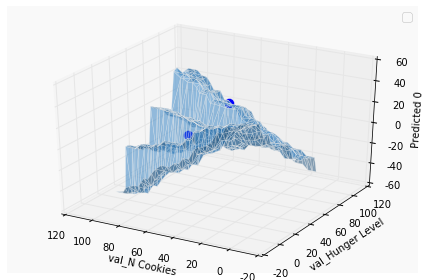

In [15]:

launch_environment()
point1 = np.array([60, 20])
point2 = np.array([60, 80])

example_idx = abs(x[:, :2] - point1).sum(axis=1).argmin()
example1 = x[example_idx]

example_idx = abs(x[:, :2] - point2).sum(axis=1).argmin()
example2 = x[example_idx]

plot_pdp_with_points(point1, point2, interpreter, gbr.predict, example1, example2)

In [17]:
#Guy who wasnt hungry
from pyinterpret.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(x, discretize_continuous=False, feature_names=['N Cookies',
                                                                               'Hunger Level',
                                                                               'Time of Day'])
explainer.explain_regressor_instance(example1, gbr.predict).show_in_notebook()

In [18]:
#Guy who was hungry
example2_idx = abs(x[:, :2] - point2).sum(axis=1).argmin()
example2 = x[example2_idx]

explainer.explain_regressor_instance(example2, gbr.predict).show_in_notebook()

#### More on Surrogates...

##### LIME is a surrogate defined on a small region, meant to explain whats going around a point.


##### Requirements:
* input data (or ability to generate reasonable data around a point, currently implemented by rescaling a standard normal sample to a point)
* ability to generate predictions from data

##### Procedure:
* pick a point to evaluate
* generate samples
* generate predictions of samples
* fit linear model f:X-> predictions, weighting observations by proximity to point
* Return coefficients

##### Challenges:
* Computational Complexity: model must be used to generate many many predictions. Currently partially overcome with intelligent sampling.
* Measuring Similarity: Currently implements rbf kernel over euclidean distances. Improvement is to use affinity scaling, which takes into account local dynamics (e.g. what if point 1 is far but in sparse region, vs medium distance but dense).
* Similarity Weighting: Degree of freedom in how to weight similarity (see plot below).

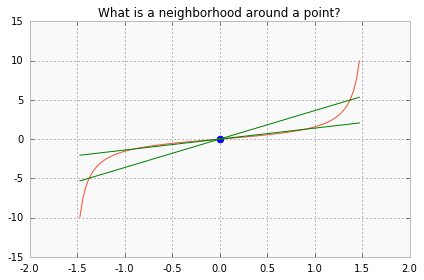

In [9]:
from pyinterpret.util import rbf_kernel
import numpy as np
pi = np.pi
epsilon = .1
x = np.linspace(-pi/2 + epsilon, pi/2 - epsilon, 100)
y = np.tan(x)
point = np.array([0,0])
f, ax = plt.subplots(1)
ax.plot(x, y)
ax.scatter(*point, color = 'blue', marker = ".", s=200.)

distances = np.array(x) ** 4
similarity = rbf_kernel(distances)

x = x[:, np.newaxis]
reg2 = LinearRegression()
reg2.fit(x, y, sample_weight=distances)
pred = reg2.predict(x)
ax.plot(x, pred, color = 'green')

reg_weighted = LinearRegression()
reg_weighted.fit(x, y, sample_weight = similarity)
pred = reg_weighted.predict(x)
ax.plot(x, pred, color = 'green')
ax.set_title("What is a neighborhood around a point?")
plt.show()

Agenda:
* Why do we need interpretations? (Pramits slides with 10-15 min)
* Introduce Interpretability (this notebook for 30 min)
* How to use the library. (demo notebooks 5 min)
* Discussion and Questions (5 min)
